In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [2]:
#Need to split the Train Set for clusters then combine with new Train of 5 seasons
nba_clustered = pd.read_csv("NBA_Train_Clustered.csv")
labels = nba_clustered[["PLAYER",'Cluster',"Cluster_Label"]]

nba_5Season_train = pd.read_csv("5YearSplitTraining.csv")
nba_clustered = nba_5Season_train.merge(labels, on='PLAYER', how='inner')
nba_clustered


,PLAYER,GP,MIN,PTS,REB,AST,STL,BLK,FG_PCT,FG3_PCT,FT_PCT,TOV,Cluster,Cluster_Label
0,A.C. Green,82.000000,17.200000,4.500000,3.800000,0.50,0.400000,0.100000,0.444000,0.0000,0.712000,0.500000,3,Bench
1,A.J. Guyton,39.000000,16.200000,5.700000,1.050000,1.85,0.250000,0.200000,0.383500,0.3825,0.824000,0.750000,4,Bust
2,AJ Hammons,22.000000,7.400000,2.200000,1.600000,0.20,0.000000,0.600000,0.405000,0.5000,0.450000,0.500000,4,Bust
3,AJ Price,47.000000,14.040000,5.400000,1.360000,2.04,0.460000,0.040000,0.381600,0.3076,0.611400,0.860000,4,Bust
4,Aaron Brooks,65.000000,22.620000,10.760000,1.700000,3.22,0.580000,0.140000,0.415400,0.3528,0.840000,1.660000,2,Role Player
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550,Zeljko Rebraca,43.000000,14.720000,5.560000,2.960000,0.36,0.240000,0.700000,0.521800,0.0000,0.789000,0.880000,3,Bench
1551,Zendon Hamilton,50.000000,12.950000,4.850000,3.950000,0.30,0.300000,0.250000,0.478500,0.0000,0.675000,0.850000,3,Bench
1552,Zion Williamson,24.000000,27.800000,22.500000,6.300000,2.10,0.700000,0.400000,0.583000,0.4290,0.640000,2.500000,0,Superstar
1553,Zoran Planinic,49.333333,10.666667,3.833333,1.333333,1.10,0.433333,0.066667,0.406667,0.2960,0.675667,0.833333,4,Bust


In [3]:
ncaa_train = pd.read_csv("College2000_2020.csv")

print(f" NBA data: {len(nba_clustered)} players")
print(f" NCAA data: {len(ncaa_train)} players")

# Merge
merged_train = pd.merge(
    ncaa_train,
    nba_clustered[['PLAYER', 'Cluster', 'Cluster_Label']],
    left_on='Name',
    right_on='PLAYER',
    how='inner'
)

print(f" Merged: {len(merged_train)} players")
print(f"\nCluster distribution:")
print(merged_train['Cluster_Label'].value_counts())

 NBA data: 1555 players
 NCAA data: 1233 players
 Merged: 1137 players

Cluster distribution:
Cluster_Label
Bust                360
Role Player         326
Bench               224
Superstar           140
All-Star/Starter     87
Name: count, dtype: int64


In [4]:
# College features (same as Logistic Regression)
college_features = [
    'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
    'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS'
]

# Check which features exist
available_features = [f for f in college_features if f in merged_train.columns]
print(f" Available features ({len(available_features)}): {available_features}")

# Create X and y
X = merged_train[available_features].copy()
y = merged_train['Cluster'].copy()

# Handle missing values
X = X.fillna(X.mean())

print(f"\n Feature matrix: {X.shape}")
print(f" Target distribution:")
print(y.value_counts().sort_index())

 Available features (17): ['G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

 Feature matrix: (1137, 17)
 Target distribution:
Cluster
0    140
1     87
2    326
3    224
4    360
Name: count, dtype: int64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f" Training: {len(X_train)} samples")
print(f" Testing: {len(X_test)} samples")

# Scaling Random Forest for consistency from past modeling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 Training: 909 samples
 Testing: 228 samples


In [6]:
# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,          # Number of trees
    max_depth=15,              # Max depth of trees
    min_samples_split=10,      # Min samples to split a node
    min_samples_leaf=4,        # Min samples at leaf node
    random_state=42,
    class_weight='balanced',   # Handle class imbalance
    n_jobs=-1,                 # Use all CPU cores
    verbose=0
)

# Train model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f" Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")


 Training Accuracy: 0.8922 (89.22%)
 Test Accuracy: 0.4561 (45.61%)


In [7]:
cluster_names = ['Superstar', 'All-Star', 'Role Player', 'Bench', 'Bust']

print(classification_report(y_test, y_test_pred,
                          target_names=cluster_names,
                          digits=3))

              precision    recall  f1-score   support

   Superstar      0.300     0.429     0.353        28
    All-Star      0.312     0.278     0.294        18
 Role Player      0.426     0.400     0.413        65
       Bench      0.526     0.667     0.588        45
        Bust      0.574     0.431     0.492        72

    accuracy                          0.456       228
   macro avg      0.428     0.441     0.428       228
weighted avg      0.468     0.456     0.456       228



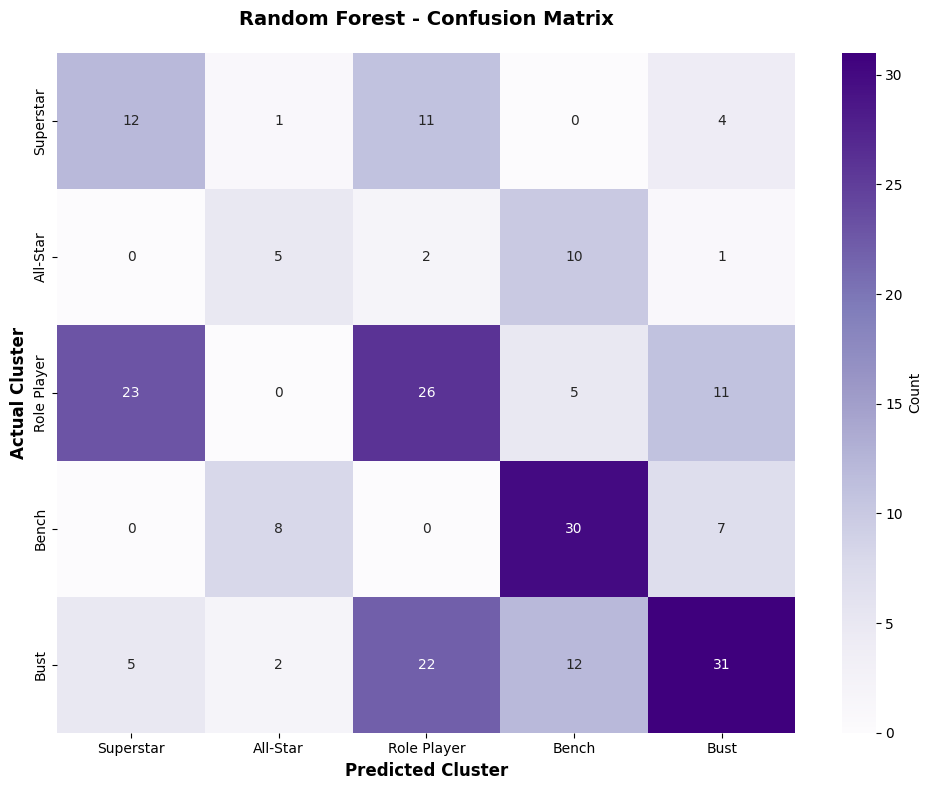


Confusion Matrix:
                    Pred Superstar  Pred All-Star  Pred Role Player  \
Actual Superstar                12              1                11   
Actual All-Star                  0              5                 2   
Actual Role Player              23              0                26   
Actual Bench                     0              8                 0   
Actual Bust                      5              2                22   

                    Pred Bench  Pred Bust  
Actual Superstar             0          4  
Actual All-Star             10          1  
Actual Role Player           5         11  
Actual Bench                30          7  
Actual Bust                 12         31  


In [8]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=cluster_names,
            yticklabels=cluster_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Actual Cluster', fontsize=12, fontweight='bold')
plt.title('Random Forest - Confusion Matrix',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm,
                     index=[f"Actual {n}" for n in cluster_names],
                     columns=[f"Pred {n}" for n in cluster_names])
print(cm_df)


 Top 10 Most Important Features:
Feature  Importance
    FG%    0.095300
    3PA    0.094966
    BLK    0.089965
    STL    0.080301
     3P    0.076461
    AST    0.075321
      G    0.071619
    TRB    0.071255
    FT%    0.046516
     MP    0.043155


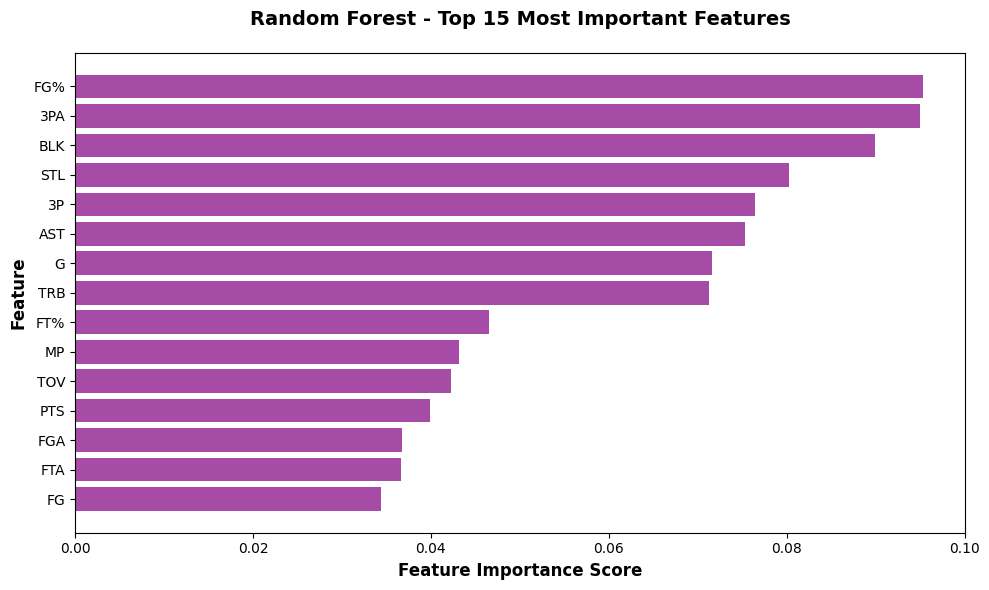

In [9]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
top_n = 15
top_features = feature_importance.head(top_n)

plt.barh(range(len(top_features)), top_features['Importance'], color='purple', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Random Forest - Top {top_n} Most Important Features',
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [10]:
# Load test data
nba_test_clustered = pd.read_csv("NBA_Test_Clustered.csv")
ncaa_test = pd.read_csv("NCAA_2020_2025.csv")

print(f" NBA test data: {len(nba_test_clustered)} players")
print(f" NCAA test data: {len(ncaa_test)} players")

# Merge test data
merged_test = pd.merge(
    ncaa_test,
    nba_test_clustered[['PLAYER', 'Cluster', 'Cluster_Label']],
    left_on='Name',
    right_on='PLAYER',
    how='inner'
)

print(f" Merged test set: {len(merged_test)} players")
print(f"\nTest set cluster distribution:")
print(merged_test['Cluster_Label'].value_counts())

# Prepare test features
X_test_2020 = merged_test[available_features].copy()
y_test_2020 = merged_test['Cluster'].copy()
X_test_2020 = X_test_2020.fillna(X_test_2020.mean())
X_test_2020_scaled = scaler.transform(X_test_2020)

# Predict
y_pred_2020 = rf_model.predict(X_test_2020_scaled)
y_pred_2020_proba = rf_model.predict_proba(X_test_2020_scaled)

# Calculate accuracy
test_acc_2020 = accuracy_score(y_test_2020, y_pred_2020)

print(f"\n Random Forest Test Accuracy (2020-2025): {test_acc_2020:.4f} ({test_acc_2020*100:.2f}%)")

 NBA test data: 368 players
 NCAA test data: 265 players
 Merged test set: 247 players

Test set cluster distribution:
Cluster_Label
Bust                121
Role Player          80
Bench                24
Superstar            13
All-Star/Starter      9
Name: count, dtype: int64

 Random Forest Test Accuracy (2020-2025): 0.5142 (51.42%)


In [11]:
print(classification_report(y_test_2020, y_pred_2020,
                          target_names=cluster_names,
                          digits=3))

              precision    recall  f1-score   support

   Superstar      0.375     0.462     0.414        13
    All-Star      0.333     0.556     0.417         9
 Role Player      0.417     0.312     0.357        80
       Bench      0.464     0.542     0.500        24
        Bust      0.609     0.645     0.627       121

    accuracy                          0.514       247
   macro avg      0.440     0.503     0.463       247
weighted avg      0.510     0.514     0.508       247



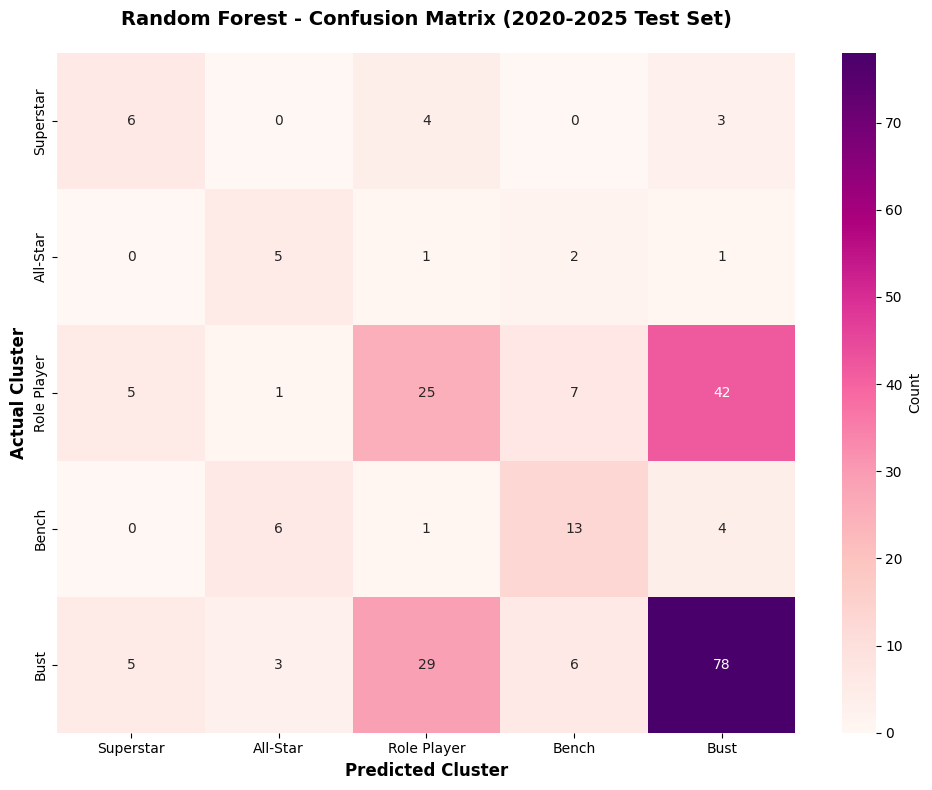

In [12]:
cm_2020 = confusion_matrix(y_test_2020, y_pred_2020)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_2020, annot=True, fmt='d', cmap='RdPu',
            xticklabels=cluster_names,
            yticklabels=cluster_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Actual Cluster', fontsize=12, fontweight='bold')
plt.title('Random Forest - Confusion Matrix (2020-2025 Test Set)',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [13]:

merged_test['Predicted_Cluster'] = y_pred_2020
merged_test['Predicted_Label'] = [cluster_names[p] for p in y_pred_2020]
merged_test['Correct'] = merged_test['Cluster'] == merged_test['Predicted_Cluster']
merged_test['Confidence'] = y_pred_2020_proba.max(axis=1)

# Correct predictions
print("\n CORRECT PREDICTIONS:")
correct = merged_test[merged_test['Correct'] == True].sort_values('PTS', ascending=False)
print(correct[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label', 'Predicted_Label']].head(15).to_string(index=False))

# Incorrect predictions
print("\n INCORRECT PREDICTIONS:")
incorrect = merged_test[merged_test['Correct'] == False].sort_values('PTS', ascending=False)
print(incorrect[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label', 'Predicted_Label']].head(15).to_string(index=False))

# High-confidence predictions
print("\n HIGH-CONFIDENCE CORRECT PREDICTIONS (>80% confidence):")
high_conf = merged_test[(merged_test['Correct'] == True) & (merged_test['Confidence'] > 0.8)].sort_values('Confidence', ascending=False)
print(high_conf[['Name', 'PTS', 'Cluster_Label', 'Confidence']].head(10).to_string(index=False))


 CORRECT PREDICTIONS:
           Name  PTS  TRB  AST    Cluster_Label Predicted_Label
  Markus Howard 21.6  3.2  3.1             Bust            Bust
Cade Cunningham 20.1  6.2  3.5        Superstar       Superstar
      Max Strus 18.6  5.8  2.5      Role Player     Role Player
      Zach Edey 18.2  9.6  1.3 All-Star/Starter        All-Star
     Luka Garza 18.2  7.3  1.2             Bust            Bust
 Paolo Banchero 17.2  7.8  3.2        Superstar       Superstar
  Dalton Knecht 16.9  5.2  1.5             Bust            Bust
    Sam Merrill 16.8  3.6  3.6             Bust            Bust
    Ayo Dosunmu 16.7  4.8  3.9      Role Player     Role Player
   Keifer Sykes 16.5  3.7  4.1             Bust            Bust
    Evan Mobley 16.4  8.7  2.4 All-Star/Starter        All-Star
   Ryan Rollins 16.4  5.6  3.1      Role Player     Role Player
  Lamar Stevens 16.3  6.5  1.9             Bust            Bust
 Onyeka Okongwu 16.2  8.6  1.1 All-Star/Starter        All-Star
  Ajay Mitchell 1